# **CS4187 - Assignment 3**

## **Students**

Boris Bobylkov - *21317097*

Italo Terto da Silva - *21326312*

Symon Szulc - *21323208*

Code compiles with no errors.

### **Resources:**

* [Tensorflow:2.1](https://www.tensorflow.org/versions/r2.10/api_docs)
* [Keras-Documentation](https://keras.io/examples/rl/deep_q_network_breakout/)
* [ALE Documentation](https://ale.farama.org/environments/breakout/)
* [Matplotlib Documentation](https://matplotlib.org/)
* [SciPy Documentation](https://docs.scipy.org/doc/)
* [Numpy Documentation](https://numpy.org/doc/1.25/)
* [OpenCV](https://pypi.org/project/opencv-python/)
* [Deque](https://docs.python.org/3/library/collections.html#collections.deque)
* [GymLibrary](https://www.gymlibrary.dev/)
* [Playing Atari with Deep Reinforcement Learning (Paper)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
* [Reinforcement Learning: Deep Q-Learning with Atari games (Blog)](https://medium.com/nerd-for-tech/reinforcement-learning-deep-q-learning-with-atari-games-63f5242440b1)
* [Hands-on machine learning with Scikit-Learn, Keras and Tensorfow](https://uol.alma.exlibrisgroup.com/leganto/public/353UOL_INST/citation/20760368120003496?auth=SAML)

## 1. **Why Reinforcement Learning is the machine learning paradigm of choice for this task?**

Reinforcement learning is one of the branches of machine learning that trying to train models in a similar way as to human learning and able to learn on its own.
This makes it one of the best choices to train a model that would play an Atari game for example.
One of the most suitable technique for this is Double Deep Quality learning (DDQN).
DDQN would allow us to train our model faster and efficiently.

In [38]:
# Import necessary libraries
import random
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow import keras
import tensorflow as tf
import cv2
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
from tensorflow.keras import layers

print("All imports worked correctley")

All imports worked correctley


In [3]:
# Configuration parameters
gamma = 0.99  # Discount factor for future rewards
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.1  # Minimum exploration rate
epsilon_max = 1.0  # Maximum exploration rate
epsilon_interval = 0.995  # Rate of decay for exploration
batch_size = 32  # Size of replay buffer batch
max_steps_per_episode = 10000  # Max steps per episode
update_target_network = 3000  # Frequency to update target network
max_memory_length = 100000  # Max size of replay buffer


# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("Set configuration parameters")

Set configuration parameters


## **2. The Gym Environment**

### **Game: Breakout**

Breakout (https://www.gymlibrary.dev/environments/atari/breakout/)

For this assignment decided to use the Atari Breakout. Reason why we selected this game:
- Gameplay loop of breakout is suitable for training DQN
  - Simple gameplay allows it to avoid overfitting to the specific level
- Short rounds
  - Reduces episode duration without affecting the training performance
- Breakout has simple visuals
  - This gives good signal-to-noise ratio

### **Game Actions**

The breakout game consists of 4 input actions. Which are Noop, Fire, Right, Left. We can see this in the following table:

TODO: Add an image of the actions table from https://ale.farama.org/environments/breakout/

Source: [ALE Doc - Breakout](https://ale.farama.org/environments/breakout/)


In [4]:
# Create the environment
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
# Set the seed during the environment reset
observation, info = env.reset(seed=seed)

print("Create an environment")

Create an environment


## **3. Implementation**

### **a. Capture and pre-processing of the data**

In this section we are going to visualise the environment before and after the preprocessing is executed.

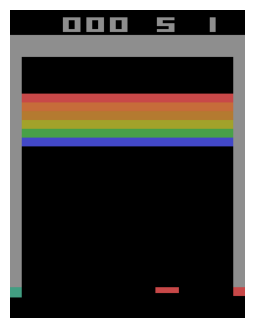

In [13]:
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
env.reset()

def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img

plot_environment(env)
plt.show()

In [17]:
outputs = env.action_space.n
input_shape = env.observation_space.shape

print(f"Outputs: ", outputs)
print(f"Input Shape: ", input_shape)

Outputs:  4
Input Shape:  (210, 160, 3)


#### **Preprocess the environment**
The purpose of following code block is to prepare the image to be processed by the model.
- Converting image to a grayscale would let us reduce processing time of the frame in the model
- Resizing is required, because original frame has dimensions of 210 x 160 x 3. In the previous point we were able to reduce 3 channels for RGB to only one channel for greyscale. Now we would reduce its size to 84 by 84.
- As a lat step we would normalize the resulting image to be in scale from 0 to 1

In [5]:
# Preprocess the environment
def preprocess_observation(observation):
    # Convert to grayscale and resize
    observation = tf.image.rgb_to_grayscale(observation)
    observation = tf.image.resize(observation, [84, 84])
    # Normalize to [0, 1]
    observation = observation / 255.0
    return observation

print("Define preprocessing")

Define preprocessing


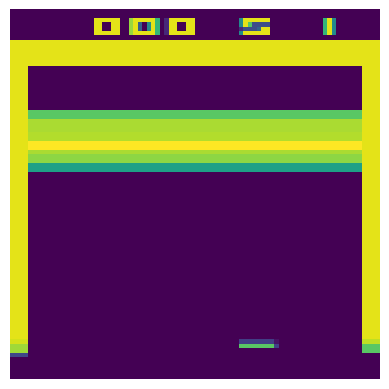

In [26]:
q_values = [0]
action = np.argmax(q_values[0])
observation, info = env.reset(seed=42)
next_state, reward, done, _, _ = env.step(action)
preprocessed = preprocess_observation(next_state)

plt.imshow(preprocessed)
plt.axis("off")
plt.show()

### **b. The Network Structure**

The way we have implemented our DQN is by using a convolutional neural network with fully connected layers.

In this network we have an input shape of (84x84x4) and the architecture goes as the following:
- 1st Convolution Layer: 32 filter, kernel size 8x8, stride 4 and ReLU activation.
- 2nd Convolution Layer: 64 filter, kernel size 4x4, stride 2 and ReLU activation.
- 3rd Convolution Layer: 64 filter, kernel size 3x3, stride 1 and ReLU activation.
- A flattening layer.
- A fully connected layer with 512 rectifier units.
- The output layer with the number of actions our environment have, which in our case is 4.

In [6]:
# Define the Q-network
def create_q_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (8, 8), strides=4, activation='relu', input_shape=(84, 84, 1)),
        layers.Conv2D(64, (4, 4), strides=2, activation='relu'),
        layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(env.action_space.n, activation='linear')
    ])
    return model

print("Define model creation function")

Define model creation function


In [7]:
# Initialize the Q-networks
model = create_q_model()
model_target = create_q_model()

print("Creation of models")

Creation of models


In [8]:
# Set the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
loss_function = tf.keras.losses.Huber()

print("Create an optimizer and loss function")

Create an optimizer and loss function


#### **Replay Buffer**

In [9]:
# Experience replay buffers
action_history = deque(maxlen=max_memory_length)
state_history = deque(maxlen=max_memory_length)
state_next_history = deque(maxlen=max_memory_length)
rewards_history = deque(maxlen=max_memory_length)
done_history = deque(maxlen=max_memory_length)

display_rewards_history = []

print("Creates history variables")

Creates history variables


#### **Training the DQN**

In this code block we have the algorithm for training the DDQN.

At the start we are setting up variables that would be required for the training or for the future plotting.
In the main loop for training we are performing standard preparation for the environment.

We are limiting duration of our episodes by ***max_steps_per_episode*** to speed up the training process.

For this assignment we used the greedy value for epsilon at the start of the episode so that model would be able to continue exploring it options and prevent sticking to the local or global minimum.
We also have a random chance that it would apply greedy epsilon.
For rest of the cases we would calculate the q-values with our main model and select best one out of them.

After that we are applying epsilon decay to reduce the reward over time

Training itself happening only if it is the 4th frame, and we have some buffer so that we would be able to perform a meaningful training of the main model.

This would loop until it would reach the average reward of 40, or it performed maximum number of episodes ***(max_episode)***

In [10]:
# Initiates training specific variables
running_reward = 0
episode_count = 0
max_episode = 700
frame_count = 0

#Stores reward value on update of target model for future plotting
episode_reward_history = []

while True:  # Run until solved
    #Set-up of environment for an episode and resets total episode reward
    state = preprocess_observation(env.reset()[0])
    episode_reward = 0

    #Limiting the duration of a episode to be 'max_steps_per_episode'
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < 50000 or epsilon > np.random.rand(1)[0]:
            #Choses random action for exploration
            action = np.random.choice(env.action_space.n)
        else:
            #Q-network generates the Q-values for all actions and selects the highest Q-value
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon *= epsilon_interval 
        epsilon = max(epsilon, epsilon_min)

        # Apply the action in the environment
        next_state, reward, done, _, _ = env.step(action)
        # Prepares next state to be processed
        next_state = preprocess_observation(next_state)
        # Updates total reward
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(next_state)
        done_history.append(done)
        rewards_history.append(reward)

        #Updates the state
        state = next_state

        # Update every fourth frame and once batch size is over 32
        if frame_count % 4 == 0 and len(done_history) > batch_size:
            # Sample from replay buffer
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Gets the sample data
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            # Build the updated Q-values for the sampled future states
            future_rewards = model_target.predict(state_next_sample, verbose=0)
            # Calculates the new Q-value
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)

            # If final frame, set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, env.action_space.n)

            with tf.GradientTape() as tape:
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation applied to the main model
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Triggers the update of the weights of the target model when reached new value of 'update_target_network'
        if frame_count % update_target_network == 0:
            # Update the target network with new weights
            model_target.set_weights(model.get_weights())
            display_rewards_history.append(running_reward)
            print(f"Running reward: {running_reward:.2f} at episode {episode_count}, frame count {frame_count}")

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)

    # Resets the running rewards after list reached size of a 100
    if len(episode_reward_history) > 100:
        del episode_reward_history[0]
    running_reward = np.mean(episode_reward_history)

    # Print after each episode
    print(f"Episode {episode_count} finished with reward {episode_reward}. Running average: {running_reward:.2f}")

    episode_count += 1

    # Condition to consider the task solved
    if running_reward > 40:
        print(f"Solved at episode {episode_count}!")
        break

    # We have this if statement because this model will take too long to complete training
    if episode_count > max_episode:
        print(f"Reached final episode: {episode_count}")
        break

Episode 0 finished with reward 0.0. Running average: 0.00
Episode 1 finished with reward 1.0. Running average: 0.50
Episode 2 finished with reward 1.0. Running average: 0.67
Episode 3 finished with reward 1.0. Running average: 0.75
Episode 4 finished with reward 2.0. Running average: 1.00
Episode 5 finished with reward 2.0. Running average: 1.17
Episode 6 finished with reward 1.0. Running average: 1.14
Episode 7 finished with reward 1.0. Running average: 1.12
Episode 8 finished with reward 2.0. Running average: 1.22
Episode 9 finished with reward 0.0. Running average: 1.10
Episode 10 finished with reward 3.0. Running average: 1.27
Episode 11 finished with reward 0.0. Running average: 1.17
Episode 12 finished with reward 0.0. Running average: 1.08
Episode 13 finished with reward 1.0. Running average: 1.07
Episode 14 finished with reward 0.0. Running average: 1.00
Episode 15 finished with reward 1.0. Running average: 1.00
Episode 16 finished with reward 0.0. Running average: 0.94
Running

In [27]:
model.save_weights('dqn_model_weights.h5')
model.save_weights('dqn_model_weights.ckpt')

model_target.save_weights('dqn_model_target_weights.h5')
model_target.save_weights('dqn_model_target_weights.ckpt')

print("Weights are saved")

Weights are saved


## **4. Plots:**

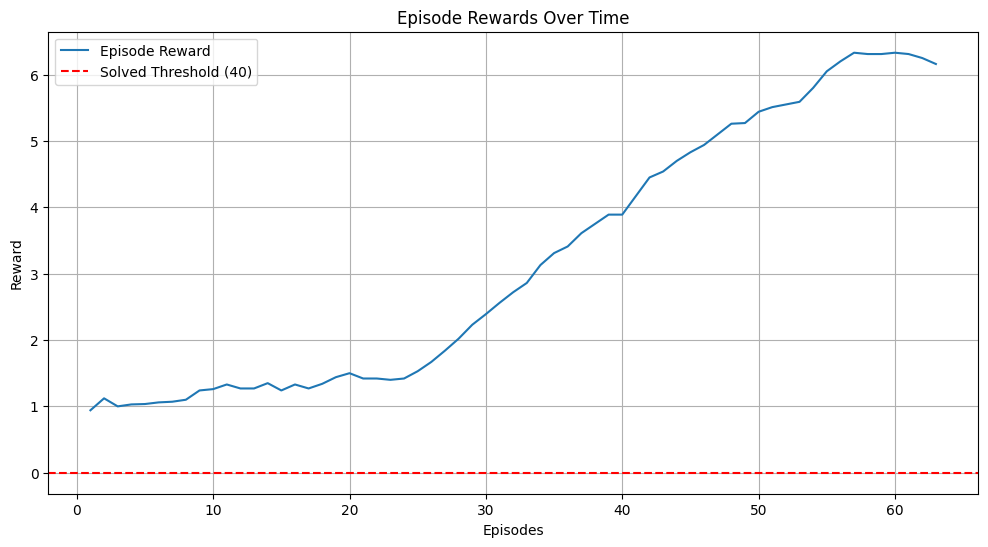

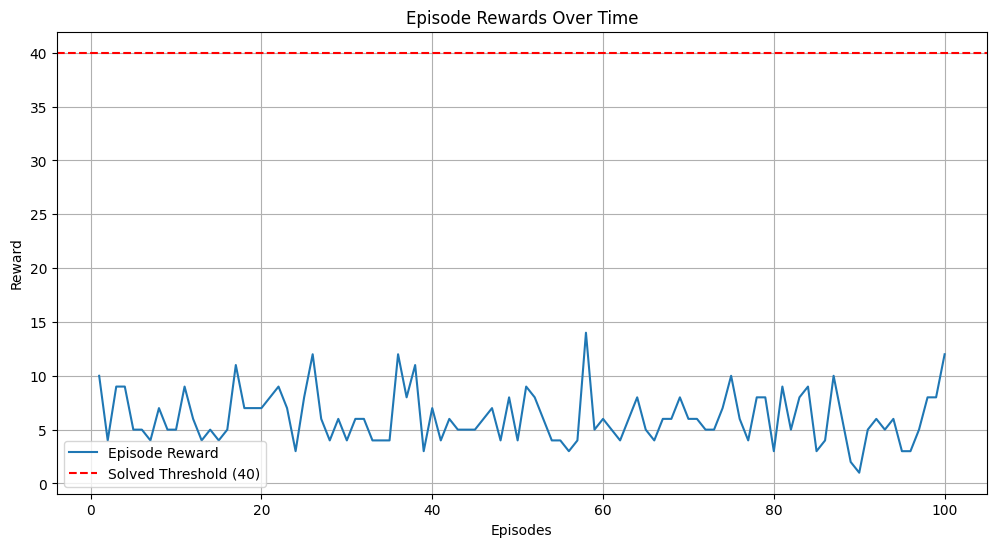

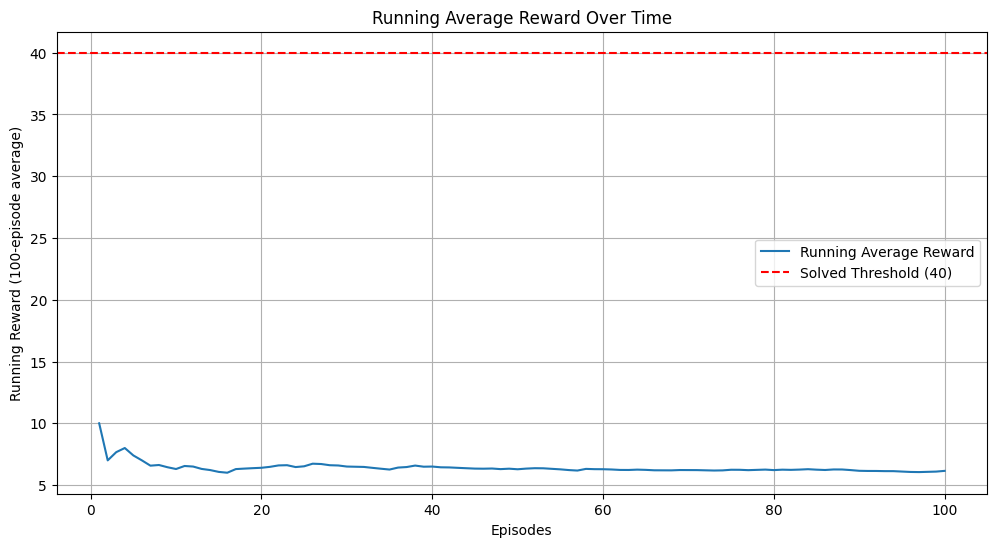

In [12]:
# Assuming episode_reward_history and running_reward are updated in your loop
# Generate x-axis data
episodes = list(range(1, len(episode_reward_history) + 1))
episodes_full = list(range(1, len(display_rewards_history) + 1))

# Plot Episode Rewards
plt.figure(figsize=(12, 6))
plt.plot(episodes_full, display_rewards_history, label="Episode Reward")
plt.axhline(color='r', linestyle='--', label="Solved Threshold (40)")
plt.title("Episode Rewards Over Time")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# Plot Episode Rewards
plt.figure(figsize=(12, 6))
plt.plot(episodes, episode_reward_history, label="Episode Reward")
plt.axhline(y=40, color='r', linestyle='--', label="Solved Threshold (40)")
plt.title("Episode Rewards Over Time")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# Plot Running Reward
running_rewards = [np.mean(episode_reward_history[max(0, i-100):i+1]) for i in range(len(episode_reward_history))]
plt.figure(figsize=(12, 6))
plt.plot(episodes, running_rewards, label="Running Average Reward")
plt.axhline(y=40, color='r', linestyle='--', label="Solved Threshold (40)")
plt.title("Running Average Reward Over Time")
plt.xlabel("Episodes")
plt.ylabel("Running Reward (100-episode average)")
plt.legend()
plt.grid()
plt.show()

## **5. Videos and plots with short accompanying explanations of the information conveyed**

Also no idea about this

In [37]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import os

model_video = create_q_model()
model_video.load_weights(r".\\dqn_model_weights.h5")
model_video.compile()

# Set up the directory for video recording
video_dir = "./videos"
os.makedirs(video_dir, exist_ok=True)

# Wrap the environment with the RecordVideo wrapper
tmp_env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env1 = RecordVideo(env=tmp_env, video_folder=video_dir, name_prefix="test-video", episode_trigger=lambda x: x % 10 == 0)
# env1.start_video_recorder()

# Training loop
num_episodes = 1
for episode in range(num_episodes):
    observation, info = env1.reset(seed=42)
    done = False
    steps = 0
    while not done and steps < 500:
        # Preprocess the observation
        steps += 1
        next_state, reward, done, _, _ = env1.step(action)
        next_state = preprocess_observation(next_state)
        next_state = tf.expand_dims(next_state, axis=0)

        # Predict the action from the model
        q_values = model_video.predict(next_state, verbose=0)
        action = np.argmax(q_values[0])  # Choose the action with the highest Q-value

        # Take the action in the environment
        observation, reward, terminated, truncated, info = env1.step(action)
        env1.render()
        done = terminated or truncated

# env1.close_video_recorder()

print(f"Videos saved to: {video_dir}")
env1.close()

Videos saved to: ./videos


## **6. Evaluation of the results**

a. How does one evaluate the performance of the RL agent?

b. Are the metrics that we have seen to date relevant?